In [41]:
#dataset reading using pandas
import pandas as pd
df=pd.read_csv("C:\\Users\\Admin\\Desktop\\data science\\final projects csv files\\Google_Stock_Price_Train.csv")

In [42]:
df

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [44]:
df.isnull().sum()    #no null values in the dataset

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [45]:
column_datatypes = df.dtypes
print(column_datatypes)            #date column is the datetime64 

Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object


Epoch [10/100], Loss: 0.0027
Epoch [20/100], Loss: 0.0019
Epoch [30/100], Loss: 0.0013
Epoch [40/100], Loss: 0.0009
Epoch [50/100], Loss: 0.0006
Epoch [60/100], Loss: 0.0004
Epoch [70/100], Loss: 0.0003
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0003
Training MAE: 0.0425
Training MSE: 0.0061
Training RMSE: 0.0781
Testing MAE: 0.0304
Testing MSE: 0.0016
Testing RMSE: 0.0397


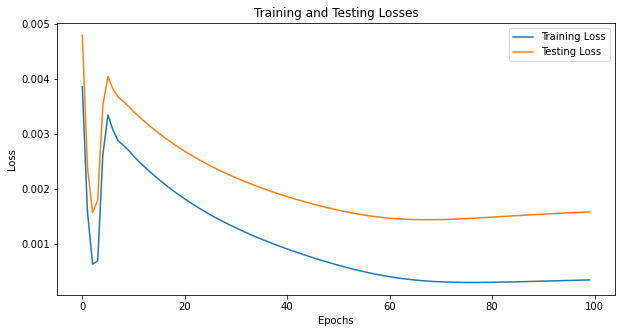

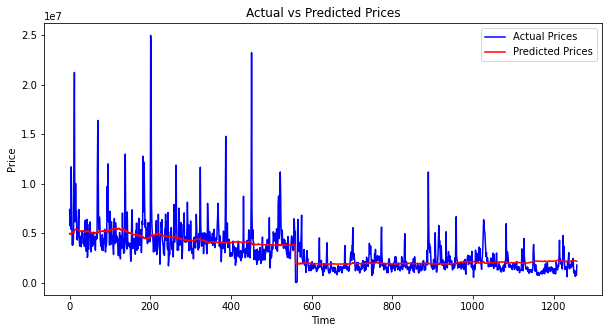

In [46]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('C:\\Users\\Admin\\Desktop\\data science\\final projects csv files\\Google_Stock_Price_Train.csv')

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sort the dataframe by date
data = data.sort_values('Date')

# Keep only the columns needed for training
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Convert 'Close' and 'Volume' columns to float
data['Close'] = data['Close'].str.replace(',', '').astype(float)
data['Volume'] = data['Volume'].str.replace(',', '').astype(float)

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Convert the data to PyTorch tensors
tensor_data = torch.tensor(data_normalized, dtype=torch.float32)

# Split data into train and test sets
train_size = int(len(tensor_data) * 0.8)
test_size = len(tensor_data) - train_size
train_data, test_data = tensor_data[:train_size], tensor_data[train_size:]

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Parameters
input_size = 4  # Number of features (excluding 'Close')
hidden_size = 64
num_layers = 2
output_size = 1  # Predicting Close price

# Instantiate the model
model = LSTM(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    for i in range(0, len(train_data)-batch_size, batch_size):
        inputs = train_data[i:i+batch_size, :-1].unsqueeze(1).to(device)  # Adjust input dimensions
        targets = train_data[i:i+batch_size, -1].unsqueeze(1).to(device)  # Adjust target dimensions

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the model on training data
    with torch.no_grad():
        train_loss = criterion(outputs, targets)
        train_losses.append(train_loss.item())

    # Evaluate the model on testing data
    with torch.no_grad():
        inputs = test_data[:, :-1].unsqueeze(1).to(device)
        targets = test_data[:, -1].unsqueeze(1).to(device)
        outputs = model(inputs)
        test_loss = criterion(outputs, targets)
        test_losses.append(test_loss.item())

# Save the trained model
torch.save(model.state_dict(), 'lstm_model.pth')

# Evaluate model on training data
train_mae, train_mse, train_rmse = evaluate(model, train_data)
print(f'Training MAE: {train_mae:.4f}')
print(f'Training MSE: {train_mse:.4f}')
print(f'Training RMSE: {train_rmse:.4f}')

# Evaluate model on testing data
test_mae, test_mse, test_rmse = evaluate(model, test_data)
print(f'Testing MAE: {test_mae:.4f}')
print(f'Testing MSE: {test_mse:.4f}')
print(f'Testing RMSE: {test_rmse:.4f}')

# Plot training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.show()

def check_predictions(model, data):
    model.eval()
    with torch.no_grad():
        inputs = data[:, :-1].unsqueeze(1).to(device)
        targets = data[:, -1].unsqueeze(1).to(device)
        outputs = model(inputs)
        # Reshape outputs and targets to match the original shape before normalization
        outputs = outputs.view(-1, 1)
        targets = targets.view(-1, 1)
        # Create numpy arrays with correct shapes for inverse transformation
        outputs_np = np.concatenate((np.zeros((outputs.shape[0], 4)), outputs.cpu().numpy()), axis=1)
        targets_np = np.concatenate((np.zeros((targets.shape[0], 4)), targets.cpu().numpy()), axis=1)
        return scaler.inverse_transform(outputs_np)[:, -1], scaler.inverse_transform(targets_np)[:, -1]

# Check predictions on testing data
predicted_prices, actual_prices = check_predictions(model, tensor_data)

# Plot predictions vs actual prices
plt.figure(figsize=(10, 5))
plt.plot(actual_prices, label='Actual Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()





In [47]:
# Plotly intearctive plot between actual close price and predicted close price 
import plotly.graph_objs as go

# Function to get predictions for each row in the dataset
def get_predictions(model, data):
    model.eval()
    with torch.no_grad():
        inputs = data[:, :-1].unsqueeze(1).to(device)
        outputs = model(inputs).squeeze().cpu().numpy()
        return outputs

# Apply manual inverse transformation
predicted_close_prices = predictions * (data['Close'].max() - data['Close'].min()) + data['Close'].min()

# Create interactive plot showing predictions for each row
fig = go.Figure()

# Plot actual close prices
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Actual Close Price', line=dict(color='blue')))

# Plot predicted close prices
fig.add_trace(go.Scatter(x=data.index, y=predicted_close_prices.flatten(), mode='lines', name='Predicted Close Price', line=dict(color='orange')))

# Set plot layout
fig.update_layout(title='Actual vs Predicted Close Price', xaxis_title='Date', yaxis_title='Close Price')

# Show plot
fig.show()
